## Instructions for running training
This code would work well if you have keras, numpy and pandas installed on your system. Also make sure that the dependencies are installed

* seaborn==0.8.1
* matplotlib==2.2.2
* opencv_python==3.4.3.18
* numpy==1.14.3
* pandas==0.23.0
* Keras==2.2.2
* scikit_learn==0.23.0

Download the data from : https://www.kaggle.com/datamunge/sign-language-mnist/download

In [2]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

Using TensorFlow backend.


# Loading the ASL dataset

In [3]:
train_df = pd.read_csv("sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [4]:
test = pd.read_csv("sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
y = test['label']

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

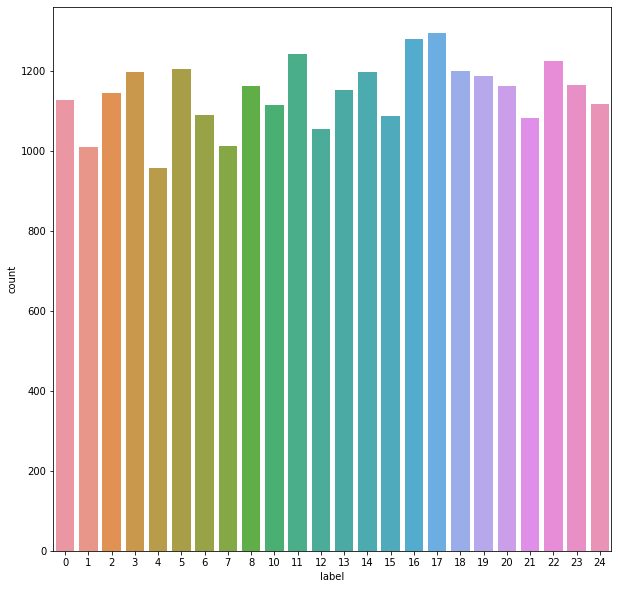

In [6]:
plt.figure(figsize = (10,10)) # Label Count
sns.countplot(train_df['label'])

**The dataset seems balanced as for each training label , enough training examples exist**

In [7]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [9]:
label_binarizer.inverse_transform(y_test)

array([ 6,  5, 10, ...,  2,  4,  2])

In [10]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [11]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [12]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

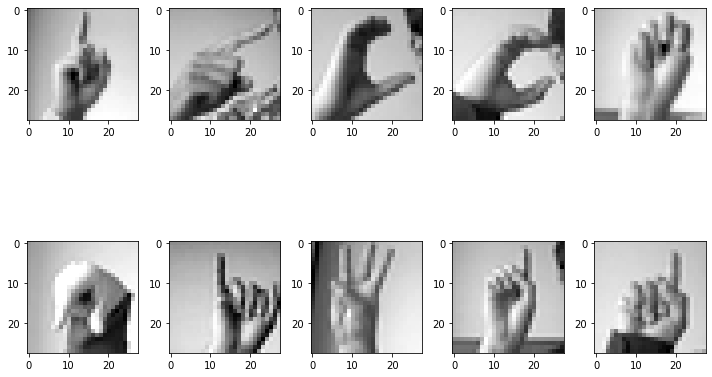

In [13]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [14]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# Training The Model

In [15]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 25)          11275     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 25)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

In [16]:
from keras.utils import plot_model

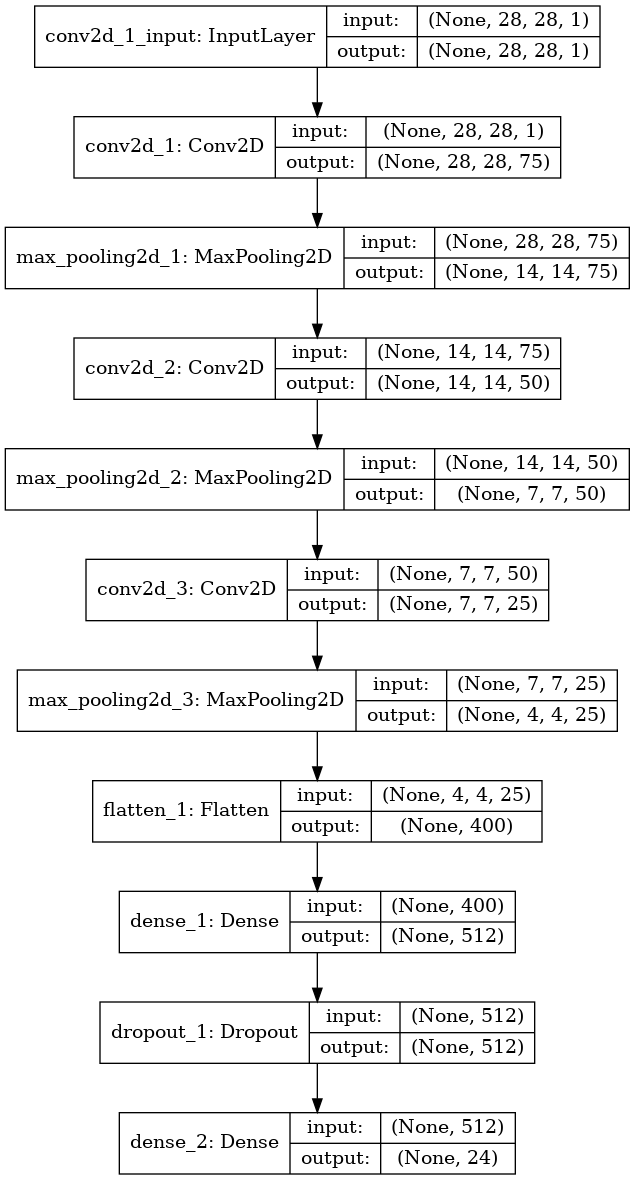

In [17]:
plot_model(model,show_shapes =True,show_layer_names=True,expand_nested=True)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test))

Epoch 1/20
215/215 [==============================] - 12s 56ms/step - loss: 2.0392 - accuracy: 0.3771 - val_loss: 0.7423 - val_accuracy: 0.7267
Epoch 2/20
215/215 [==============================] - 8s 38ms/step - loss: 0.6897 - accuracy: 0.7721 - val_loss: 0.3492 - val_accuracy: 0.8847
Epoch 3/20
215/215 [==============================] - 9s 40ms/step - loss: 0.3643 - accuracy: 0.8791 - val_loss: 0.1571 - val_accuracy: 0.9494
Epoch 4/20
215/215 [==============================] - 8s 39ms/step - loss: 0.2314 - accuracy: 0.9243 - val_loss: 0.1038 - val_accuracy: 0.9690
Epoch 5/20
215/215 [==============================] - 8s 37ms/step - loss: 0.1585 - accuracy: 0.9486 - val_loss: 0.0786 - val_accuracy: 0.9764
Epoch 6/20
215/215 [==============================] - 8s 39ms/step - loss: 0.1151 - accuracy: 0.9629 - val_loss: 0.0460 - val_accuracy: 0.9881
Epoch 7/20
215/215 [==============================] - 8s 36ms/step - loss: 0.0886 - accuracy: 0.9719 - val_loss: 0.0479 - val_accuracy: 0.985

In [19]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

7172/7172 [==============================] - 1s 74us/step
Accuracy of the model is -  99.7071921825409 %


# Analysis after Model Training

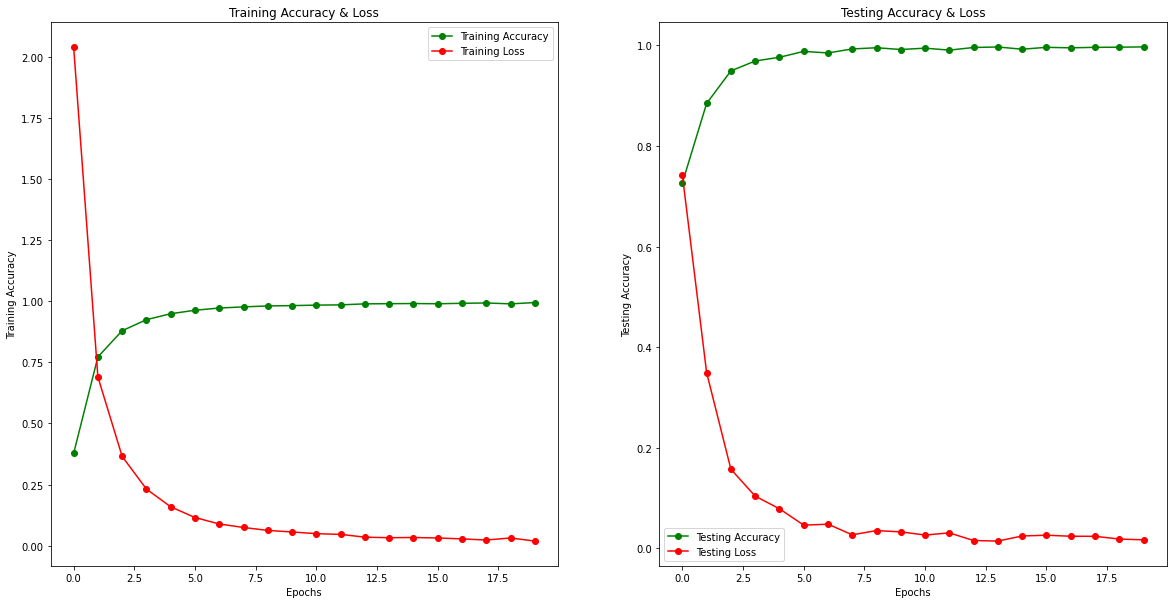

In [20]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(20,10)
ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , train_loss , 'ro-' , label = 'Training Loss')
ax[0].set_title('Training Accuracy & Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Training Accuracy")
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
ax[1].plot(epochs , test_acc , 'g-o' , label = 'Testing Accuracy')
ax[1].plot(epochs , test_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Testing Accuracy")
plt.show()

In [21]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

array([ 6,  5, 10,  0,  3])

In [22]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       0.96      1.00      0.98       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      0.94      0.97       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       0.99      1.00      1.00       144
    Class 18       1.00    

In [24]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

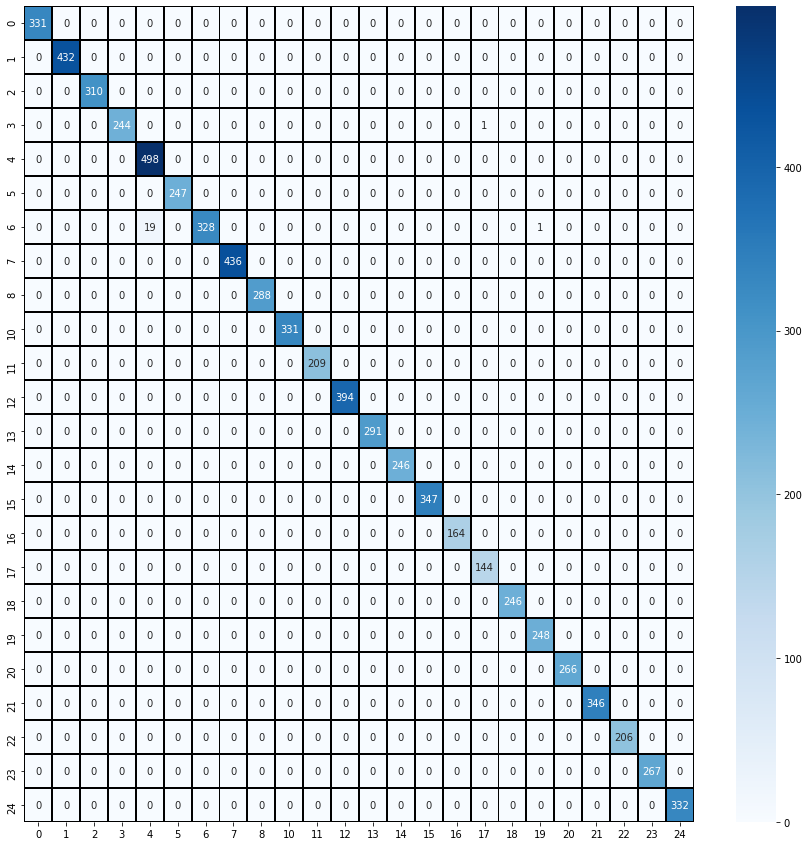

In [25]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [26]:
correct = np.nonzero(predictions == y)[0]
incorrect = np.nonzero(predictions != y)[0]

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


**Some of the Correctly Predicted Classes**

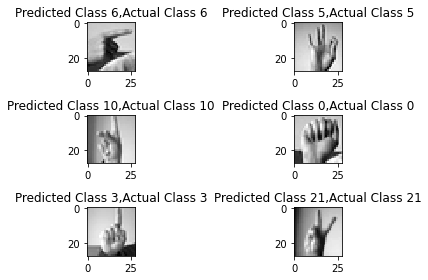

In [27]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

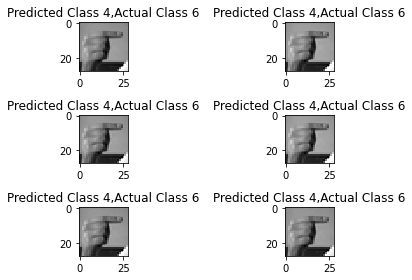

In [28]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

**Looks like most of the errors take place when the actual class label is 6**

In [29]:
model.save('iteration6.h5')

### Testing on Real webcam images

In [31]:
from keras.preprocessing.image import load_img, img_to_array
import cv2

In [34]:
# label_map
labels =  {0: 'A',1: 'B',2: 'C',3: 'D',4: 'E',
           5: 'F',6: 'G',7: 'H',8: 'I',9: 'J',
           10: 'K',11: 'L',12: 'M',13: 'N',14: 'O',
           15: 'P',16: 'Q',17: 'R',18: 'S',19: 'T',
           20: 'U',21: 'V',22: 'W',23: 'X',24: 'Y',
           25: 'Z'}

In [35]:
def get_prediction(image_path):
    resized_image = img_to_array(load_img(image_path, target_size=(28,28),grayscale=True)) / 255
    expanded_image = np.expand_dims(resized_image, axis=0)
    prediction = model.predict(expanded_image)
    return labels[np.argmax(prediction,axis=1)[0]]

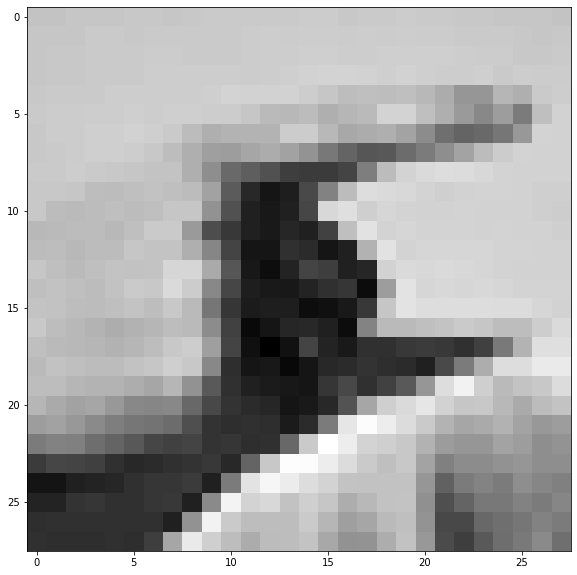

G


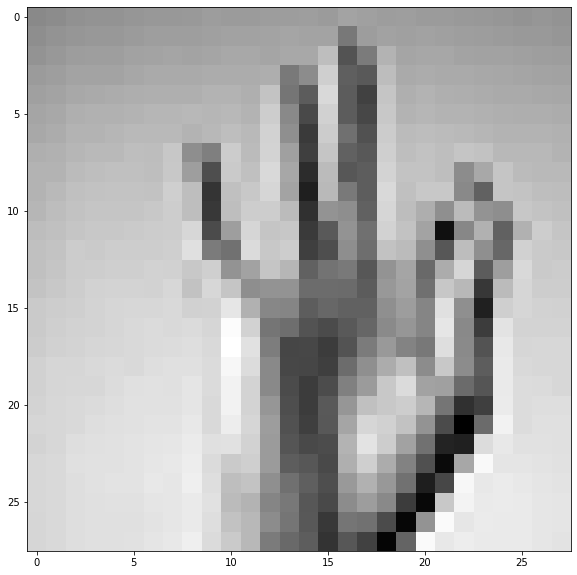

F


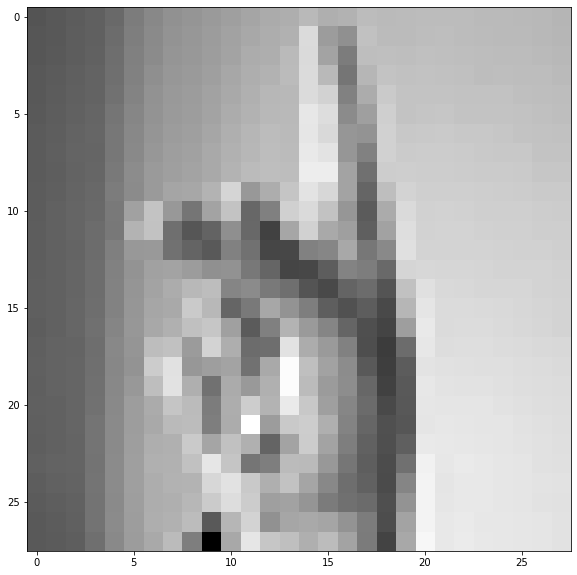

J


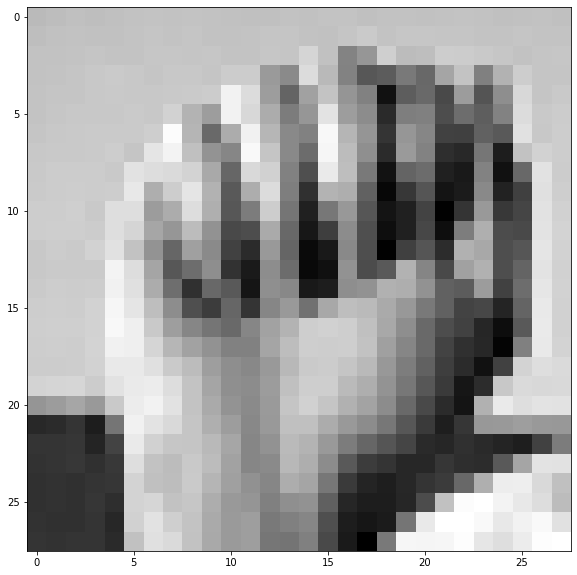

A


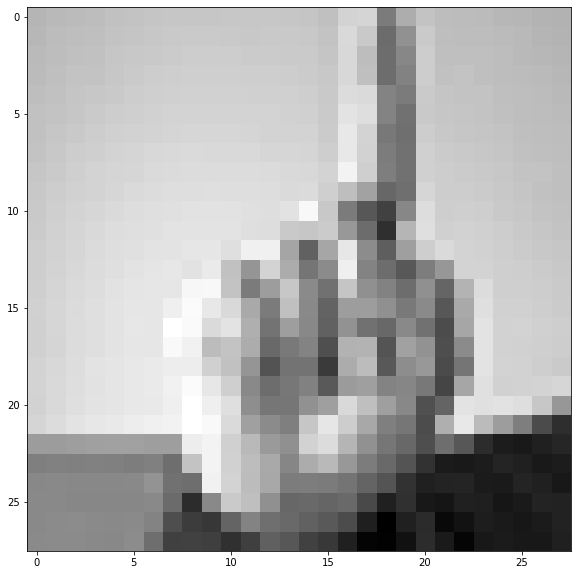

D


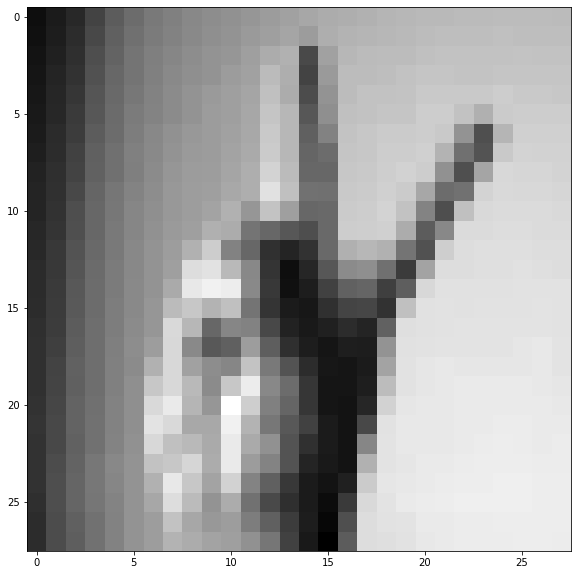

U


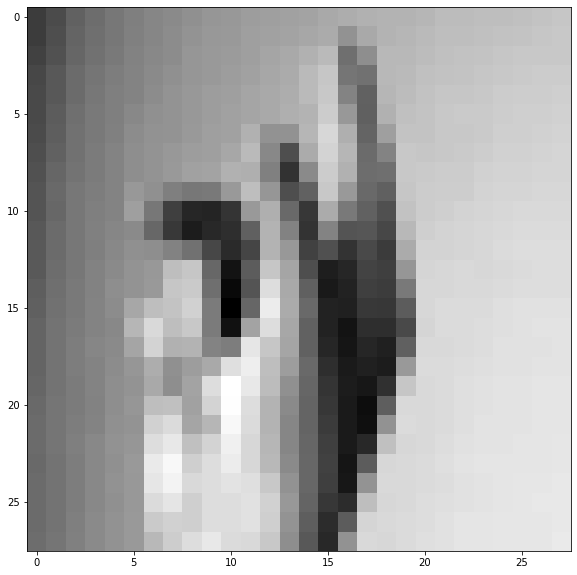

J


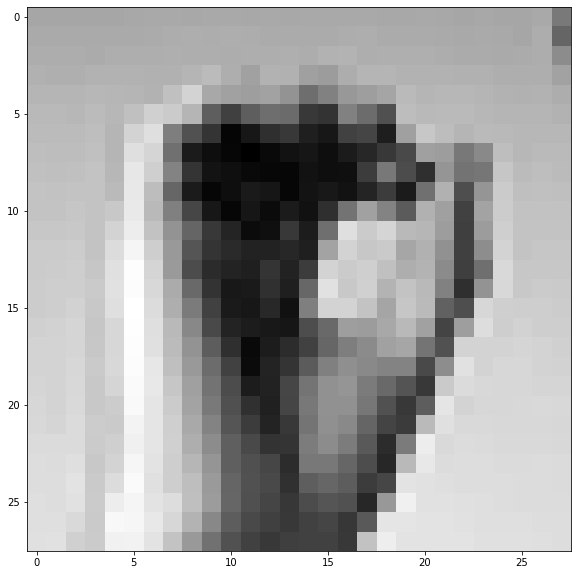

N


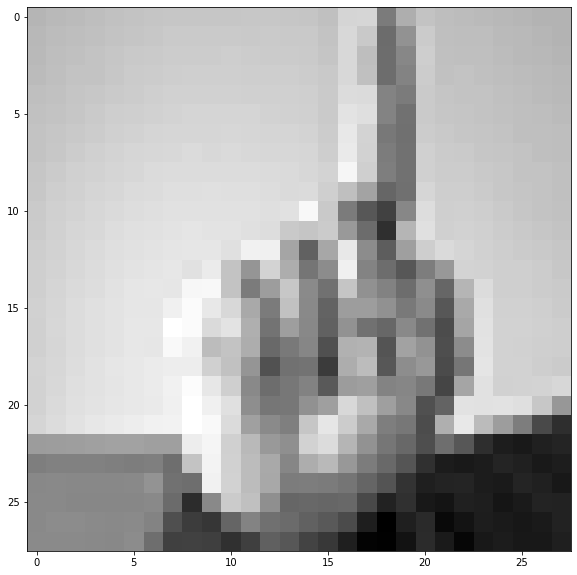

D


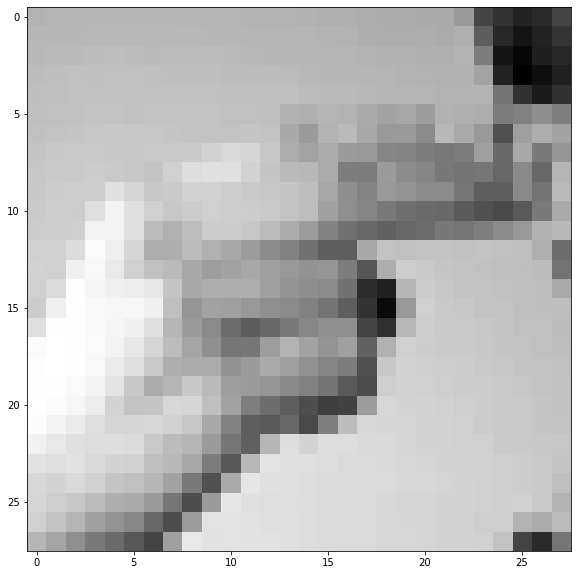

H


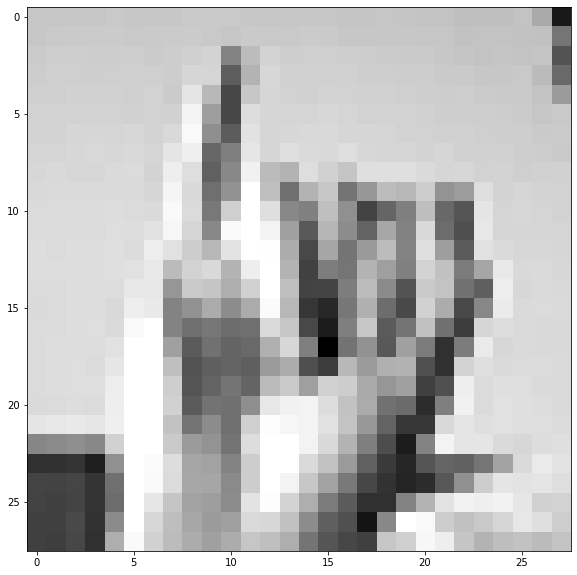

I


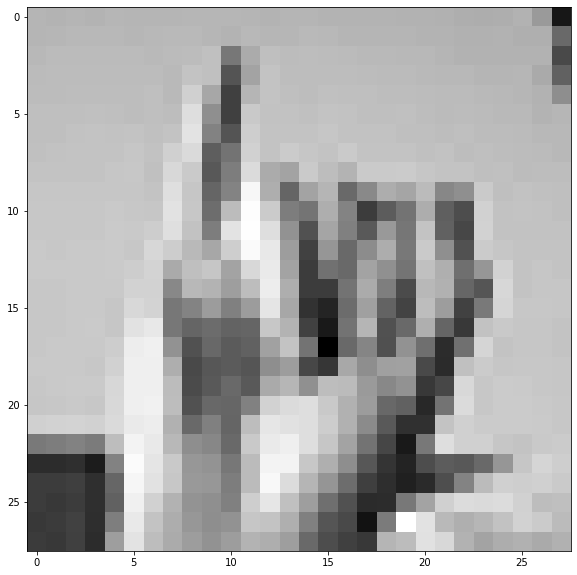

I


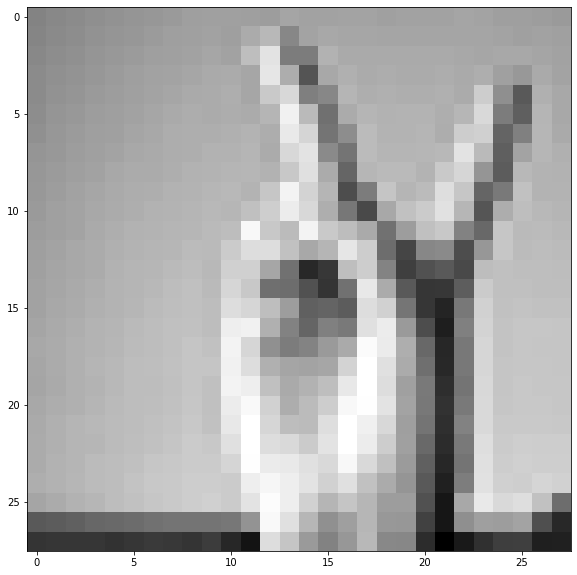

U


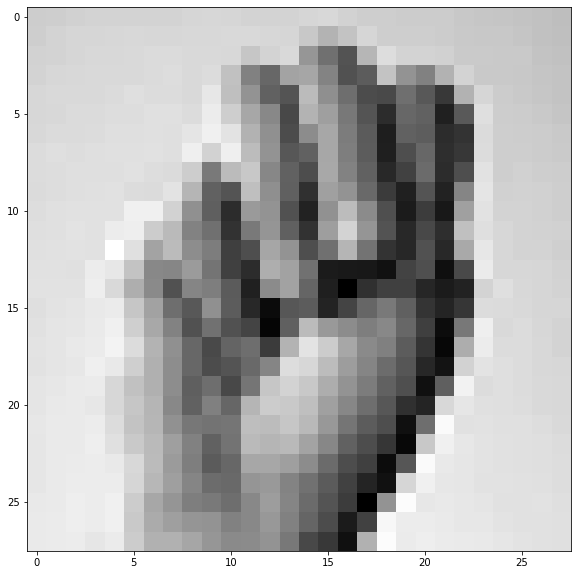

L


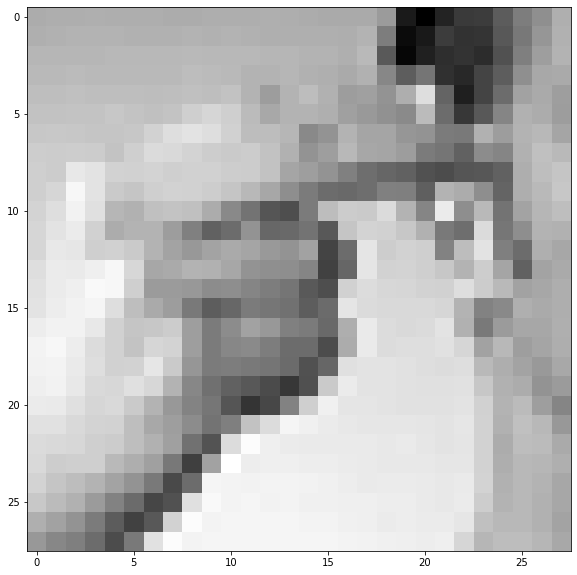

H


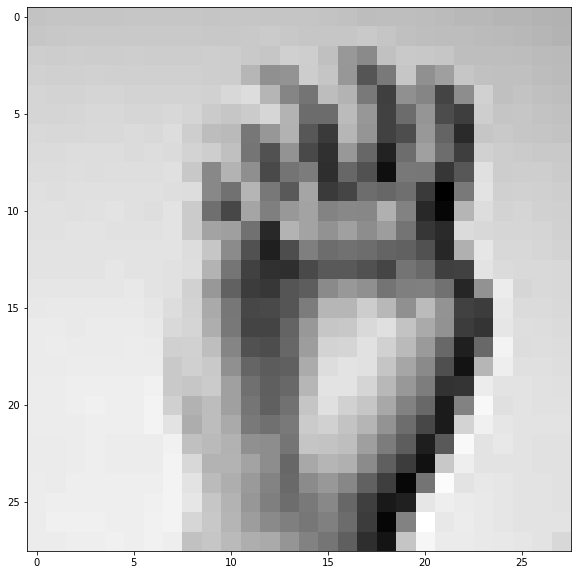

E


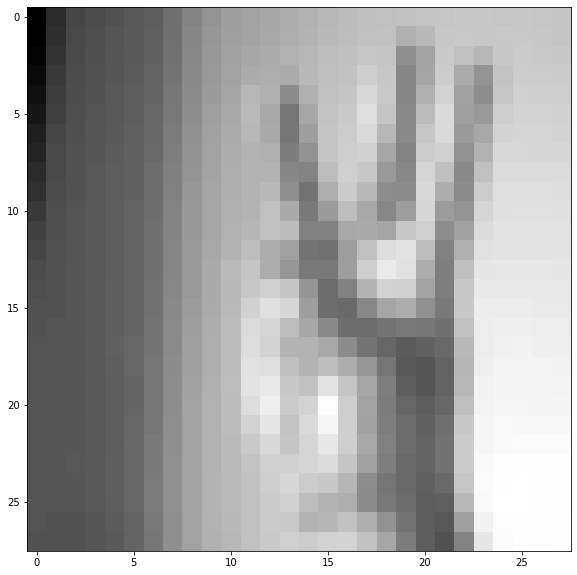

V


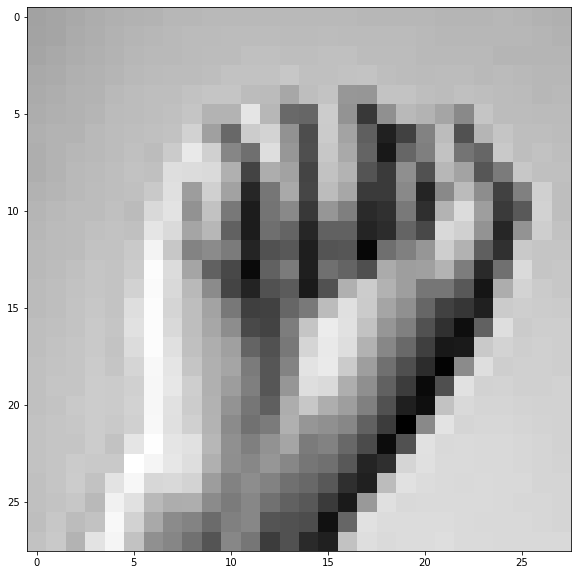

A


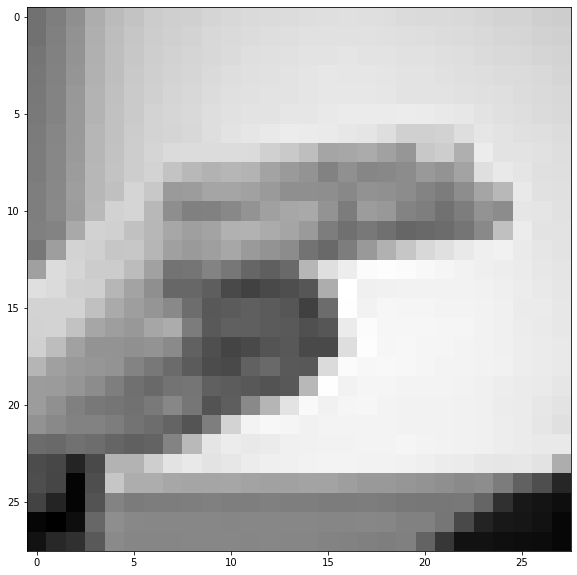

H


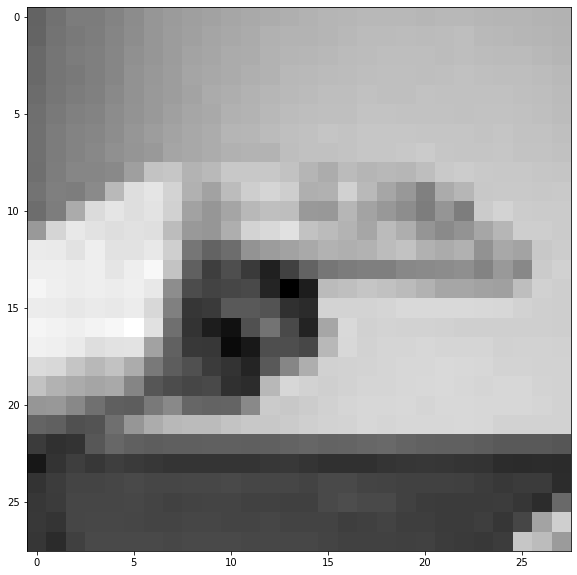

H


In [37]:
count = 0 
for each,target in zip(x_test,y_test):
    expanded_image = np.expand_dims(each, axis=0)
    plt.figure(figsize=(10,10))
    plt.imshow(each.reshape(28,28), cmap="gray", interpolation='none')
    plt.show()
    print(labels[np.argmax( model.predict(expanded_image),axis=1)[0]])
    count += 1
    if count == 20:
        break

## Final code for inference in read world images

In [39]:
class InferASL:
    """
    Usage:
    >> asl = InferASL('path_to_model') # or load_model('model_path.h5')
    >> asl.get_prediction(image_path)
    """
    def __init__(self,model):
        """
        takes in a keras model or a string
        """
        if isinstance(model,str):
            self.model = load_model(model)
        else:
            self.model = model

        self.labels = {0: 'A',1: 'B',2: 'C',3: 'D',4: 'E',
                       5: 'F',6: 'G',7: 'H',8: 'I',9: 'J',
                       10: 'K',11: 'L',12: 'M',13: 'N',14: 'O',
                       15: 'P',16: 'Q',17: 'R',18: 'S',19: 'T',
                       20: 'U',21: 'V',22: 'W',23: 'X',24: 'Y',
                       25: 'Z'} 

    def get_prediction(self,image_path):
        """
        Description:
        Takes in an image path and returns a prediction from the loaded model.
        """
        resized_image = img_to_array(load_img(image_path, target_size=(28,28),grayscale=True)) / 255
        expanded_image = np.expand_dims(resized_image, axis=0)
        prediction = model.predict(expanded_image)
        return labels[np.argmax(prediction,axis=1)[0]]
    


In [40]:
def show_image(image_path):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cv2.imread(image_path))
    plt.show()

In [41]:
real = [os.path.join('realworld/',each) for each in os.listdir('realworld/')]

In [42]:
asl = InferASL(model)

## Preliminary Tests on Webcam

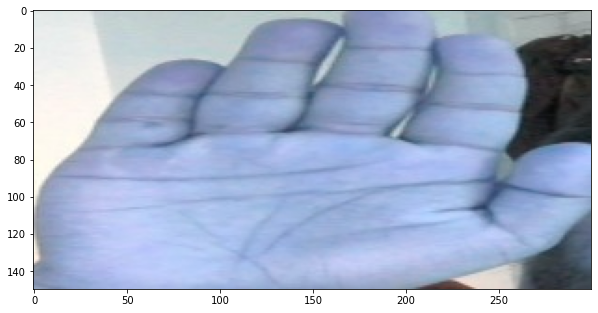

A


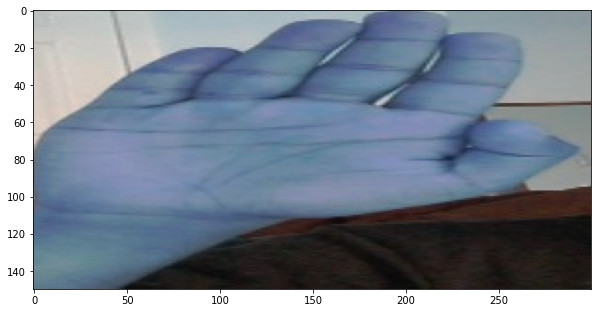

E


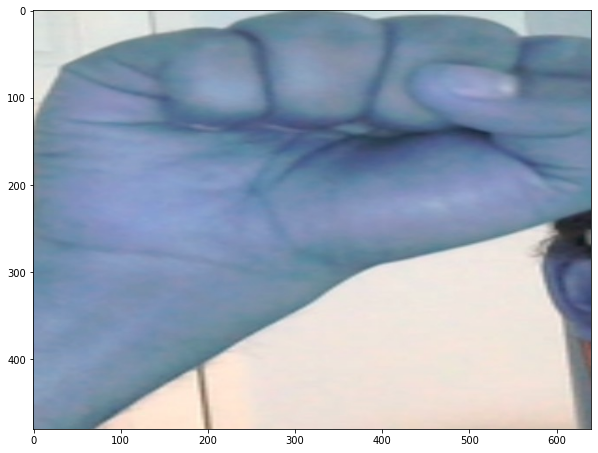

H


In [43]:
for each in real:
    show_image(each)
    print(asl.get_prediction(each))

## Note to self.
Images need to be at scale.
Lets make sure that webcam images are not stretched; otherwise we'll have to include stretching inside data augmentation. 
MaskRCNN or Handtrack.js could be looked into. 